In [3]:
%matplotlib inline
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# the activity of place cells will be characterized in a
# grid with 1cm spacing in a 1m^2 area

xy = list()
for i in range(100):
    for j in range(100):
        xy.append([i, j])
xy = np.array(xy) / 100

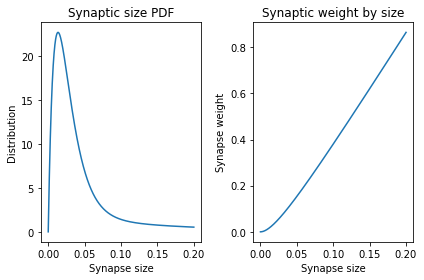

In [5]:
# each place cell will be connected to 1200 random 
# grid cells with synaptic weights determined as a
# function of synaptic sizes drawn from a distribution
# empirically measured by Trommald and Hulleberg (1997)

def synaptic_size_distribution(s):
    A = 100.7
    B = 0.02
    sigma_1 = 0.022
    sigma_2 = 0.018
    sigma_3 = 0.15
    distribution = A*(1-np.e**(-s/sigma_1))* \
        (np.e**(-s/sigma_2)+B*np.e**(-s/sigma_3))
    return distribution

synaptic_weight = lambda s: s/0.2 * s/(s + 0.0314)

s = np.linspace(0, 0.2, num=1200)
dist = synaptic_size_distribution(s)

plt.subplot(121)
plt.plot(s, dist*np.ones(1200))
plt.title("Synaptic size PDF")
plt.xlabel("Synapse size")
plt.ylabel("Distribution")

weights = synaptic_weight(s)

plt.subplot(122)
plt.plot(s, weights)
plt.title("Synaptic weight by size")
plt.xlabel("Synapse size")
plt.ylabel("Synapse weight")

plt.tight_layout()

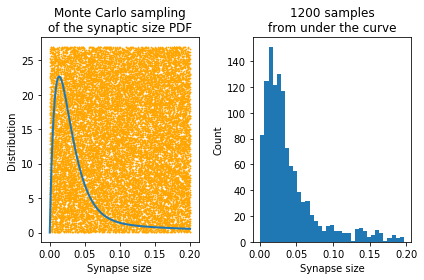

In [6]:
# 1200 samples are generated from the synaptic size 
# distribution using a Monte Carlo method

random_coordinates = np.array([
    np.random.uniform(0, 0.2, size=20000),
    np.random.uniform(0, 27, size=20000)])

plt.subplot(121)
plt.scatter(
    random_coordinates[0,:], 
    random_coordinates[1,:],
    s=0.5, c="orange")
plt.plot(s, dist, lw=2)
plt.title("Monte Carlo sampling\nof the synaptic size PDF")
plt.xlabel("Synapse size")
plt.ylabel("Distribution")

distribution_height = synaptic_size_distribution(random_coordinates[0,:])
in_dist_index = distribution_height > random_coordinates[1,:]
population = random_coordinates[0, in_dist_index]
sample_idx = np.random.randint(0, len(population), size=1200)
sample = population[sample_idx]

plt.subplot(122)
plt.hist(sample, 35);
plt.title("1200 samples\nfrom under the curve")
plt.xlabel("Synapse size")
plt.ylabel("Count")

plt.tight_layout()

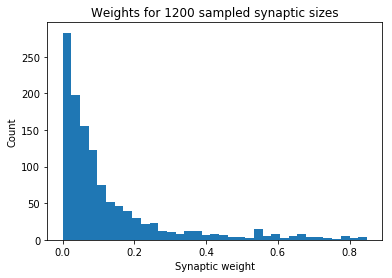

In [7]:
# synaptic weights are calculated for the 1200
# sampled synaptic sizes. for now, these weights 
# will be shuffled and reused across cells

weights = synaptic_weight(sample)
plt.hist(weights, 35);
plt.title("Weights for 1200 sampled synaptic sizes")
plt.xlabel("Synaptic weight")
plt.ylabel("Count")

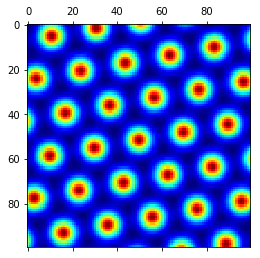

In [41]:
def grids(xy):
    c = np.random.uniform(size=2)
    _lambda = np.random.uniform(0.2, 1.0)
    theta = np.random.choice(
        [0.0, 0.34906585, 0.6981317]) # 0, 20, 40 degrees
    rotation_matrix = np.array([
        [np.cos(theta), -np.sin(theta)], 
        [np.sin(theta), np.cos(theta)]
        ])
    w_k = np.array(
        [[np.cos(np.pi/2),np.sin(np.pi/2)], 
         [np.cos(np.pi/6),np.sin(np.pi/6)], 
         [np.cos(np.pi/6),np.sin(-np.pi/6)]])
    w_k = np.dot(w_k, rotation_matrix)
    rate = np.zeros(10000)
    for i in range(10000):
        r = xy[i,:]
        vals = np.zeros(3)
        for j in range(3):
            spacing = (4*np.pi)/(3**0.5*_lambda)
            vals[j] = np.cos(spacing*np.dot(w_k[j,:], (r-c)))
        rate[i] = np.sum(vals)
    return rate

g = lambda x: np.exp(0.3 * (x+3/2))-1
G = lambda xy: g(grids(xy))
rate = G(xy)

im_matrix = np.zeros((100, 100))
i_rate = 0
for i in range(100):
    for j in range(100):
        im_matrix[i, j] = rate[i_rate]
        i_rate += 1
plt.matshow(im_matrix, cmap="jet")

In [ ]:
# simulate activity of 10000 grid cells

grid_cells = np.array([G(xy) for _ in range(10000)])

In [ ]:
fname = "/Users/danielacker/Desktop/place-field-synapse-turnover/grid_cells.npy"
np.save(file=fname, arr=grid_cells)

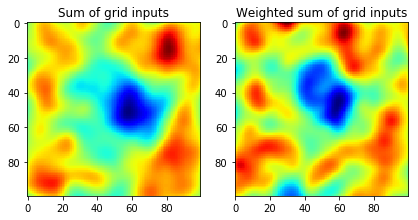

In [676]:
# comparison of firing rates of 1200 summed grid cell 
# inputs versus summed weighted inputs over the xy grid

input_idx = np.random.randint(0, 10000, size=1200)
input_grid_cells = grid_cells[input_idx, :]
summed_inputs = np.sum(input_grid_cells, axis=0)
weighted_summed_inputs = np.dot(weights, input_grid_cells)

plt.subplot(121)
im_matrix = np.zeros((100, 100))
i_rate = 0
for i in range(100):
    for j in range(100):
        im_matrix[i, j] = summed_inputs[i_rate]
        i_rate += 1
plt.imshow(im_matrix, cmap="jet")
plt.title("Sum of grid inputs")

plt.subplot(122)
im_matrix = np.zeros((100, 100))
i_rate = 0
for i in range(100):
    for j in range(100):
        im_matrix[i, j] = weighted_summed_inputs[i_rate]
        i_rate += 1
plt.imshow(im_matrix, cmap="jet")
plt.title("Weighted sum of grid inputs")

plt.tight_layout()

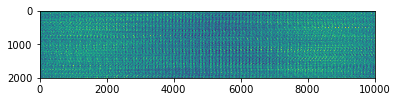

In [677]:
# calculate the weighted input to 2000 place cells 
# at each position

place_cell_activity = np.zeros((2000, 10000))
for i in range(2000):
    input_idx = np.random.randint(0, 10000, size=1200)
    input_grid_cells = grid_cells[input_idx, :]
    weighted_summed_inputs = np.dot(weights, input_grid_cells)
    place_cell_activity[i, :] = weighted_summed_inputs
    
plt.imshow(place_cell_activity)

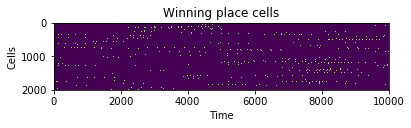

In [705]:
place_cell_winners = np.zeros((2000, 10000))
for i in range(10000):
    maximum = np.max(place_cell_activity[:,i])
    idx = place_cell_activity[:,i] > maximum*0.95
    place_cell_winners[idx,i] = place_cell_activity[idx,i]

plt.imshow(place_cell_winners)
plt.title("Winning place cells")
plt.xlabel("Time")
plt.ylabel("Cells")

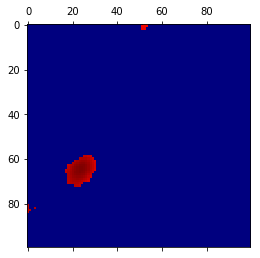

In [717]:
active = list()
for i in range(2000):
    activity = np.sum(place_cell_winners[i,:] > 0)
    if activity > 0:
        active.append(i)


cell = place_cell_winners[active[998],:]
im_matrix = np.zeros((100, 100))
i_rate = 0
for i in range(100):
    for j in range(100):
        im_matrix[i, j] = cell[i_rate]
        i_rate += 1
plt.matshow(im_matrix, cmap="jet")